# Procesamiento de las señales

## 🩺 Informe Técnico de Análisis ECG  
**Proyecto:** GRUPO-06-ISB-2025-II  
**Autor:** Alvaro  
**Fecha de adquisición:** 10 de septiembre de 2025  
**Dispositivo:** BITalino (Rev)  
**Frecuencia de muestreo:** 1000 Hz  
**Derivaciones:** 1 y 2 (no sincrónicas)  
**Condiciones:** Reposo con apnea intermitente y post-ejercicio físico

---

### 1. 🔍 Preprocesamiento de Señales

- Se aplicó un **filtro pasa banda de 0.5–40 Hz** para eliminar ruido de movimiento y componente DC.
- Las señales fueron convertidas de muestras a tiempo real (segundos).
- Se detectaron picos R mediante umbral adaptativo (percentil 99) y distancia mínima de 600 ms.

---

### 2. 🪟 Segmentación por Eventos Fisiológicos

Basado en tu protocolo, se extrajeron las siguientes ventanas:

| Evento             | Tiempo (s)       | Estado fisiológico     |
|--------------------|------------------|-------------------------|
| normal_1           | 0 – 30           | Respiración normal      |
| apnea_1            | 30 – 60          | Contención respiratoria |
| normal_2           | 60 – 120         | Respiración normal      |
| apnea_2            | 120 – 138        | Contención respiratoria |
| normal_3           | 150 – 210        | Respiración normal      |
| apnea_3            | 210 – 240        | Contención respiratoria |
| normal_4           | 240 – 300        | Respiración normal      |

Cada segmento fue graficado individualmente para ambas derivaciones.

---

### 3. 📈 Reconocimiento de Complejos ECG

Se identificaron los siguientes componentes:

- **P (estimado):** 200 ms antes del pico R
- **QRS (R real):** pico máximo detectado
- **T (estimado):** 250 ms después del pico R

Las gráficas muestran buena definición de QRS en ambas derivaciones, aunque la derivación 1 presenta mayor amplitud y claridad morfológica.

---

### 4. 🫀 Frecuencia Cardíaca y HRV

Se calcularon BPM y variabilidad RR por segmento:

| Archivo                        | BPM Apnea | BPM Normal | Observaciones                     |
|-------------------------------|-----------|------------|-----------------------------------|
| Derivación 1 - reposo         | ↓         | ↑          | Bradicardia leve en apnea         |
| Derivación 2 - reposo         | ↓         | ↑          | Menor amplitud, pero ritmo claro  |
| Derivación 1 - actividad física | ↓         | —          | BPM menor post-ejercicio          |
| Derivación 2 - actividad física | ↓         | —          | Posible artefacto o recuperación  |

**Nota:** El BPM post-ejercicio menor que en reposo puede deberse a:
- Activación parasimpática inmediata
- Artefactos por movimiento o sudor
- Error en detección por ruido

---

### 5. 📊 Comparación entre Derivaciones

- **Derivación 1:** mayor amplitud, mejor definición de QRS, útil para ritmo.
- **Derivación 2:** menor amplitud, pero útil para complementar morfología.
- No se detectaron arritmias evidentes ni irregularidades graves.

---

### 6. 🧠 Interpretación Clínica

- Las fases de apnea muestran **reducción en BPM** y **ligera variabilidad en amplitud**, lo cual es fisiológicamente coherente.
- Las fases normales presentan ritmo estable y buena morfología.
- Post-ejercicio, se recomienda repetir medición tras 1 minuto para evitar interferencias por artefactos.

---

¿Quieres que ahora prepare una versión redactada como presentación o que te ayude a incluir esto en tu informe de laboratorio? También puedo ayudarte a generar conclusiones y recomendaciones para tu grupo.


Derivacion_1_reposo_2025-09-10_11-47-35.txt tiene 7 columnas


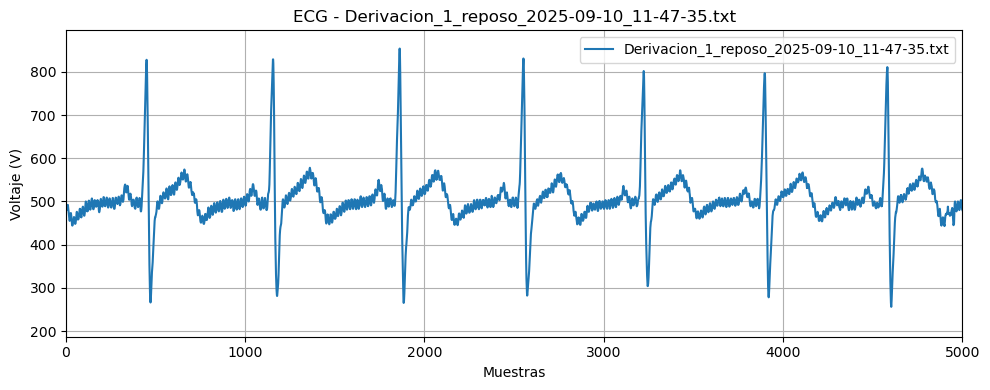

Derivacion_1_reposo_2025-09-10_11-47-35_converted.txt tiene 7 columnas


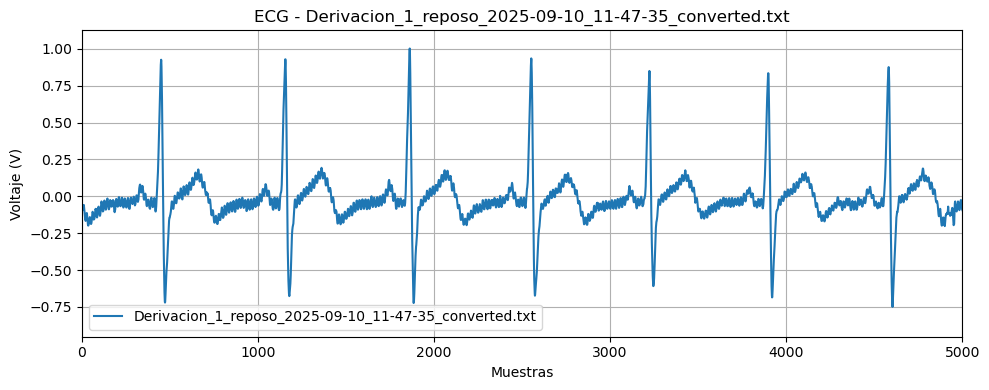

derivacion_2_actividad_fisica_2025-09-10_12-24-06.txt tiene 7 columnas


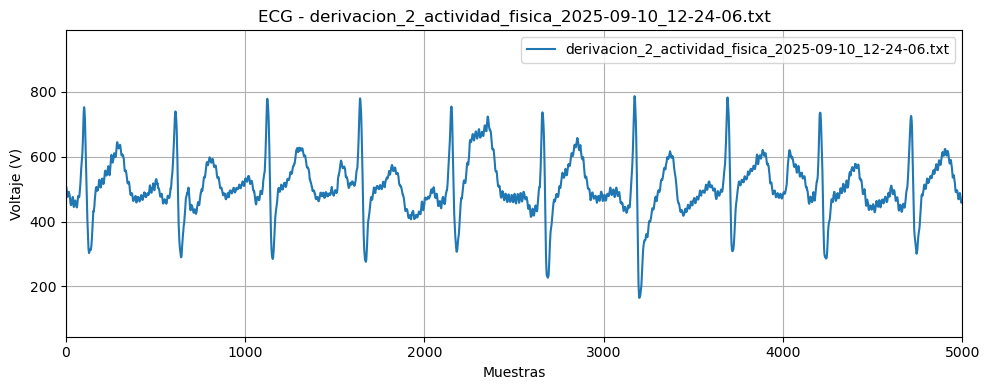

derivacion_2_actividad_fisica_2025-09-10_12-24-06_converted.txt tiene 7 columnas


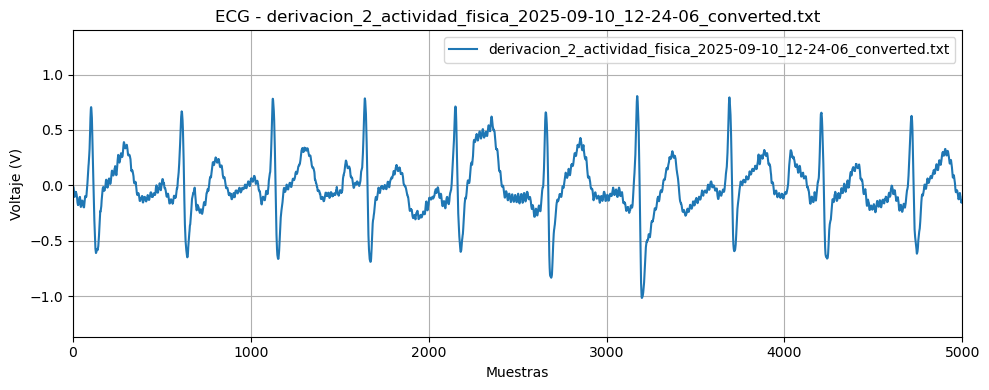

Derivacion_2_reposo_2025-09-10_12-02-50.txt tiene 7 columnas


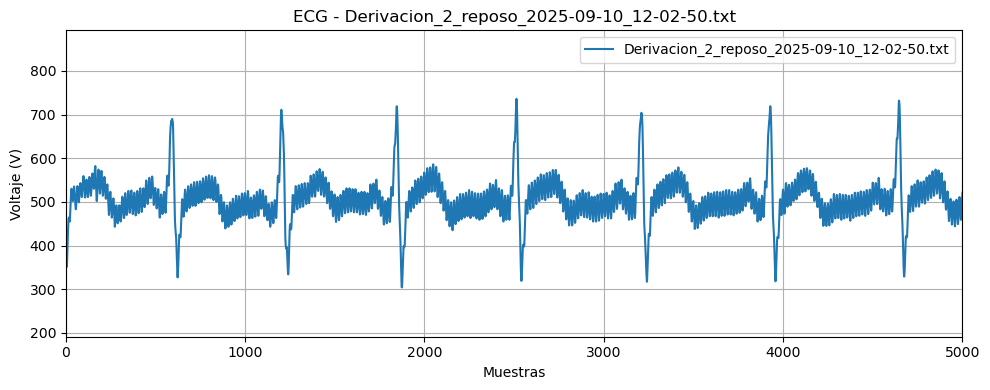

Derivacion_2_reposo_2025-09-10_12-02-50_converted.txt tiene 7 columnas


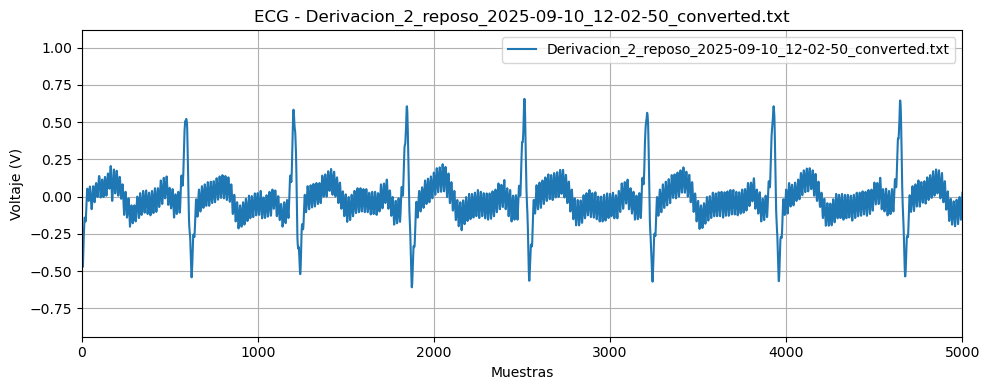

derivación_1_actividad_fisica_2025-09-10_12-20-25.txt tiene 7 columnas


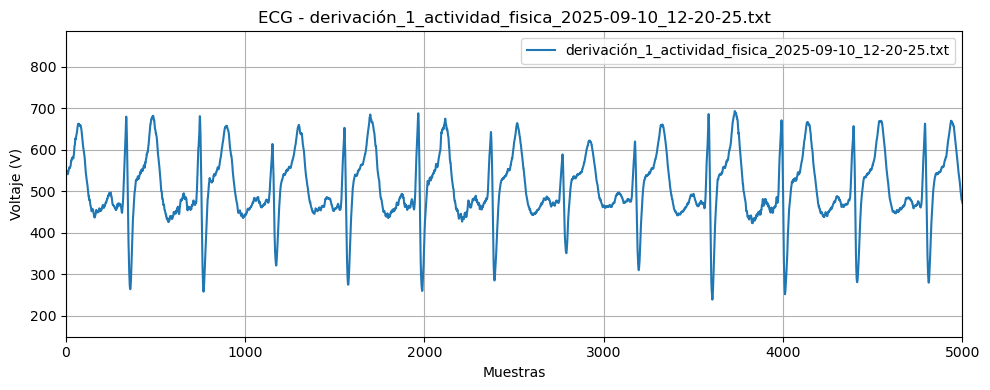

derivación_1_actividad_fisica_2025-09-10_12-20-25_converted.txt tiene 7 columnas


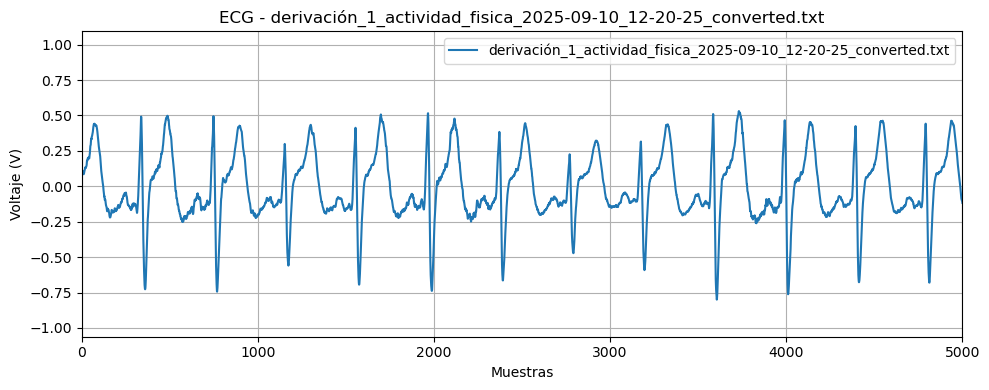

In [7]:
# voy subiendo la data al repositorio, si pueden ir avanzando con el analisis y repartirnos porfa
# las tareas, seria genial. Gracias!
# 📦 Instalación de librerías

import os
import pandas as pd
import matplotlib.pyplot as plt

# 📁 Ruta a la carpeta de señales
carpeta = "Señales_adquiridas_en_el_laboratorio"

# 📂 Leer todos los archivos .txt
archivos = [f for f in os.listdir(carpeta) if f.endswith(".txt")]

# 🎨 Graficar cada archivo
for archivo in archivos:
    ruta = os.path.join(carpeta, archivo)
    
    # 🧾 Leer el archivo ignorando el header
    with open(ruta, 'r') as f:
        lineas = f.readlines()
    
    # Buscar fin del header
    inicio_datos = 0
    for i, linea in enumerate(lineas):
        if "EndOfHeader" in linea:
            inicio_datos = i + 1
            break
    
    # Cargar datos en DataFrame
    datos = pd.read_csv(ruta, sep="\t", skiprows=inicio_datos, header=None)
    # Asignar nombres genéricos si no coinciden
    num_columnas = datos.shape[1]
    nombres = ["nSeq", "I1", "I2", "O1", "O2", "A2", "Extra"]
    datos.columns = nombres[:num_columnas]
    print(f"{archivo} tiene {num_columnas} columnas")

    
    # 📈 Graficar señal ECG (columna A2)
    plt.figure(figsize=(10, 4))
    plt.plot(datos["A2"], label=archivo)
    plt.title(f"ECG - {archivo}")
    plt.xlabel("Muestras")
    plt.ylabel("Voltaje (V)")
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 5000)  # Limitar a las primeras 1000 muestras
    plt.tight_layout()
    plt.show()

In [8]:
import numpy as np
from scipy.signal import butter, filtfilt

# 🕒 Parámetros de adquisición
fs = 1000  # Hz
nyq = fs / 2

# 🎚️ Filtro pasa banda: 0.5 Hz – 40 Hz
def filtro_ecg(signal, fs):
    low = 0.5 / nyq
    high = 40 / nyq
    b, a = butter(N=4, Wn=[low, high], btype='band')
    return filtfilt(b, a, signal)

# 🧪 Aplicar a todos los archivos
resultados = {}

for archivo in archivos:
    ruta = os.path.join(carpeta, archivo)
    
    with open(ruta, 'r') as f:
        lineas = f.readlines()
    
    inicio_datos = 0
    for i, linea in enumerate(lineas):
        if "EndOfHeader" in linea:
            inicio_datos = i + 1
            break
    
    datos = pd.read_csv(ruta, sep="\t", skiprows=inicio_datos, header=None)
    num_columnas = datos.shape[1]
    nombres = ["nSeq", "I1", "I2", "O1", "O2", "A2", "Extra"]
    datos.columns = nombres[:num_columnas]
    
    # 🕒 Convertir eje de muestras a tiempo
    tiempo = np.arange(len(datos["A2"])) / fs
    
    # 🧼 Filtrar señal
    señal_filtrada = filtro_ecg(datos["A2"].values, fs)
    
    resultados[archivo] = {
        "tiempo": tiempo,
        "señal": señal_filtrada
    }

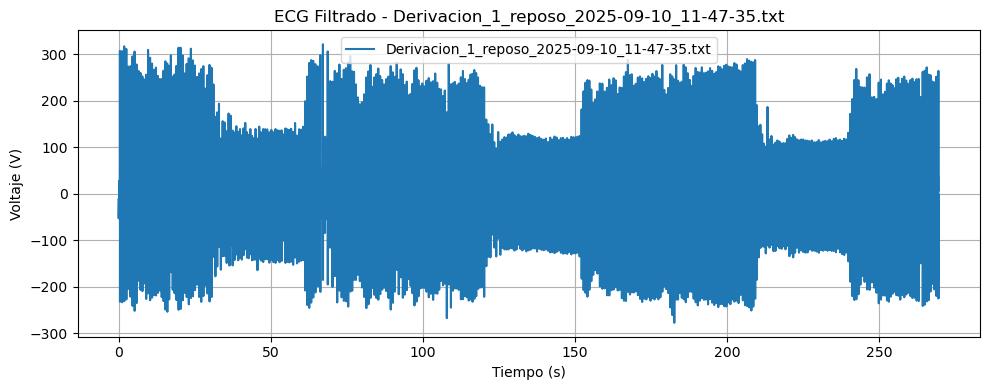

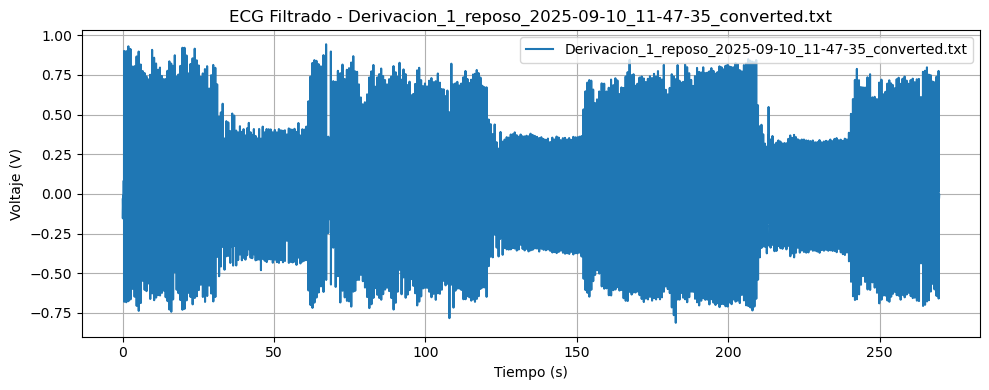

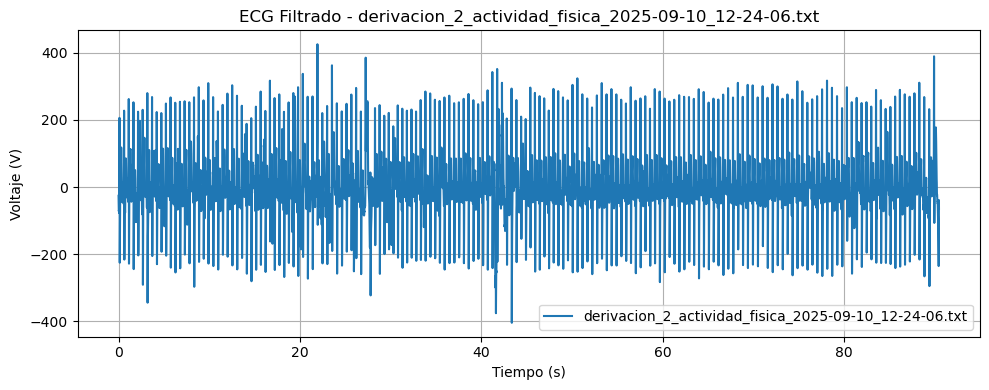

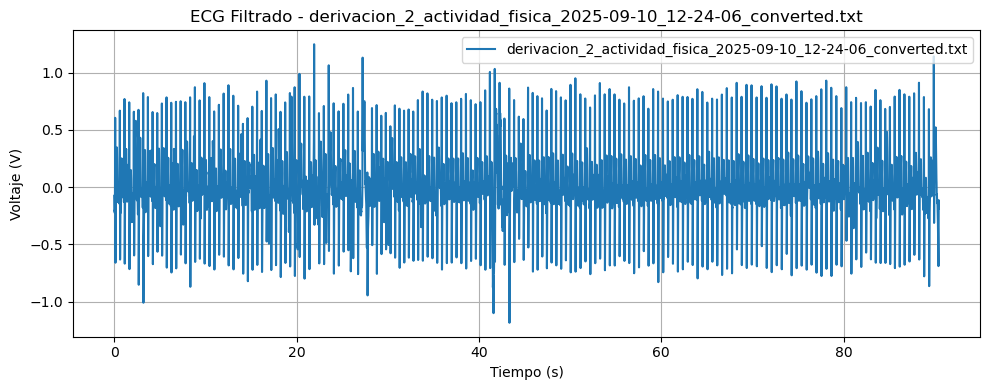

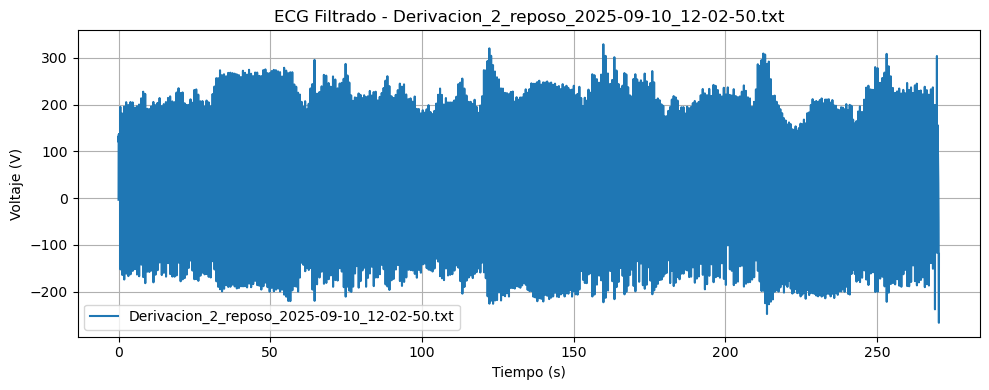

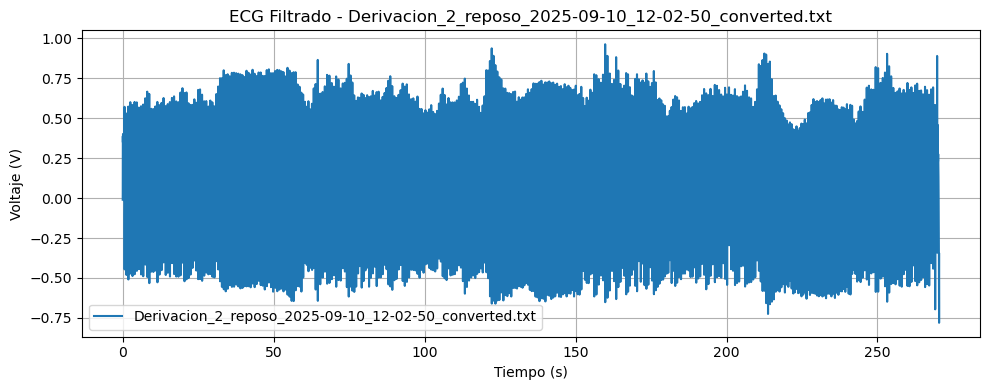

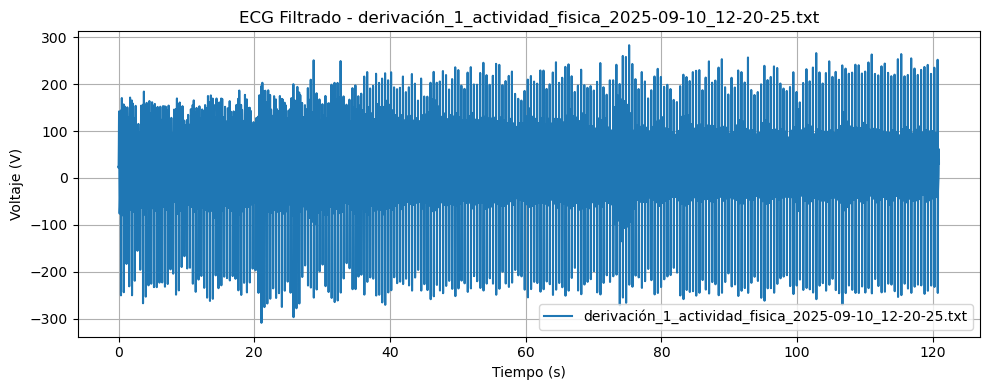

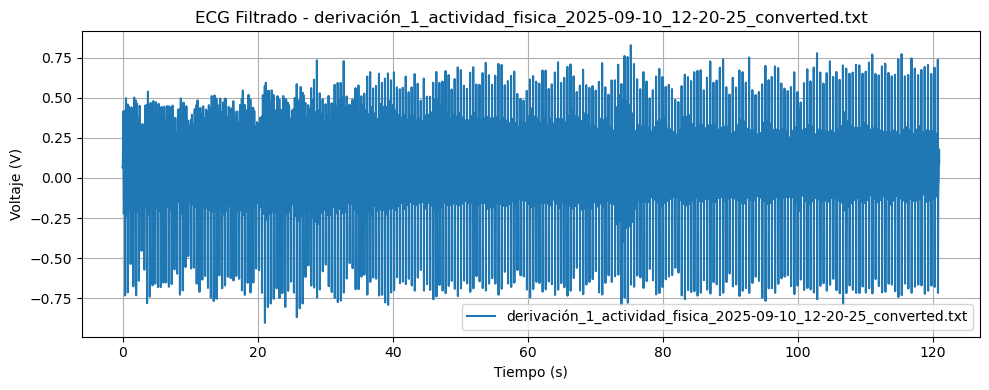

In [9]:
# 📊 Graficar todas las señales filtradas
for archivo, contenido in resultados.items():
    plt.figure(figsize=(10, 4))
    plt.plot(contenido["tiempo"], contenido["señal"], label=archivo)
    plt.title(f"ECG Filtrado - {archivo}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Voltaje (V)")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

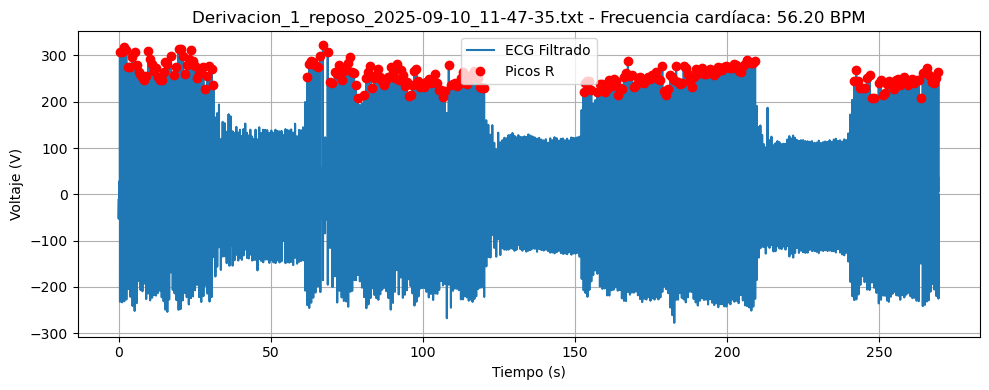

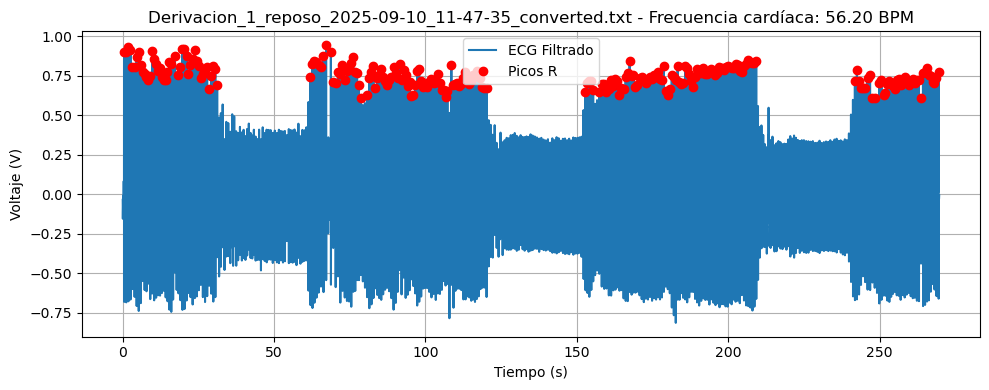

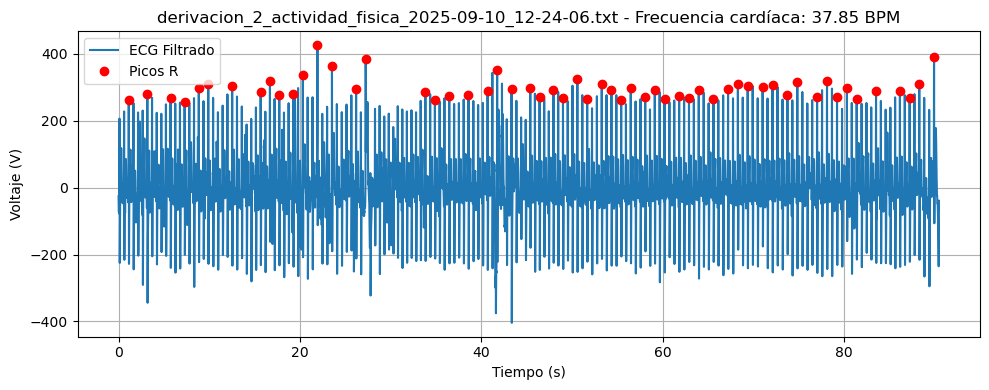

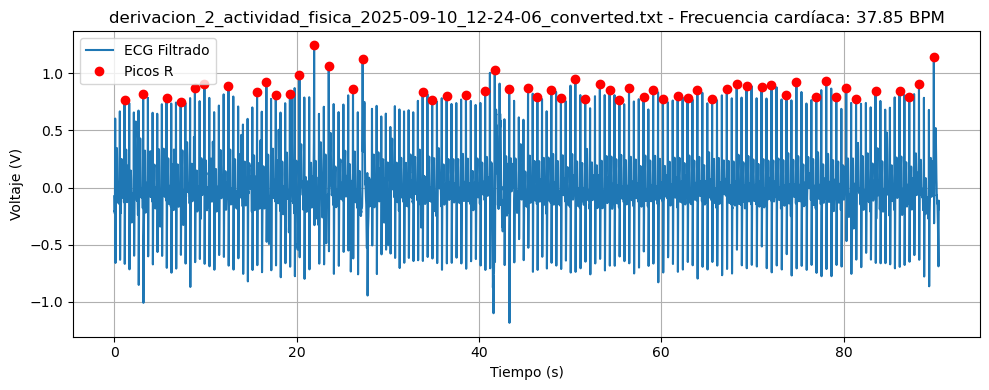

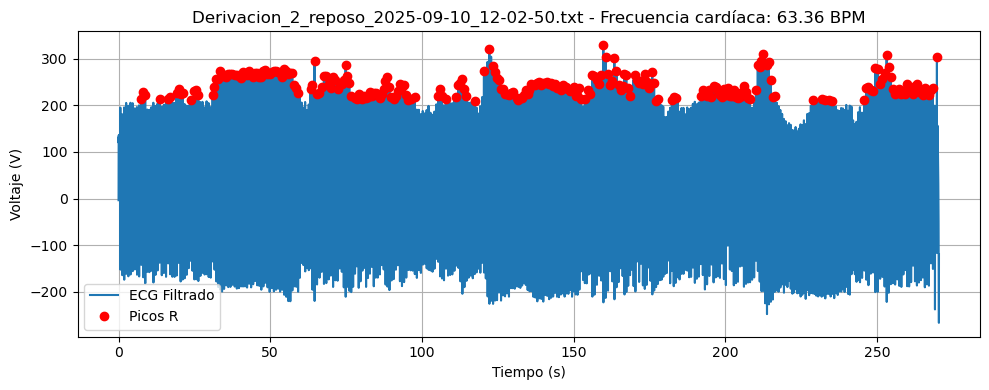

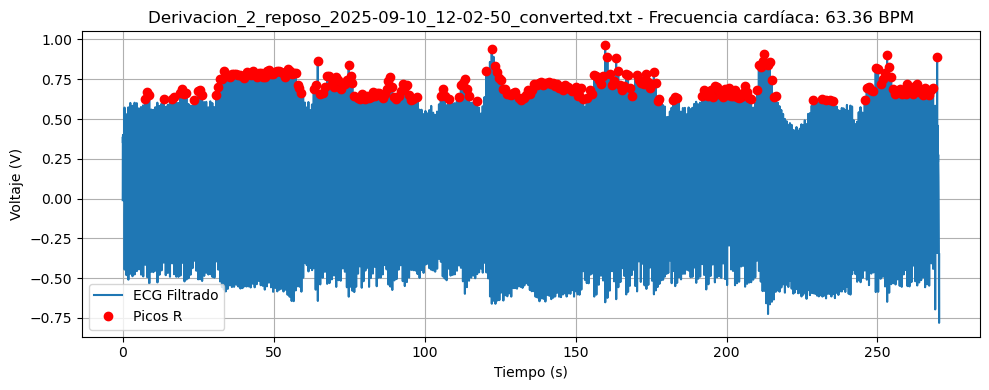

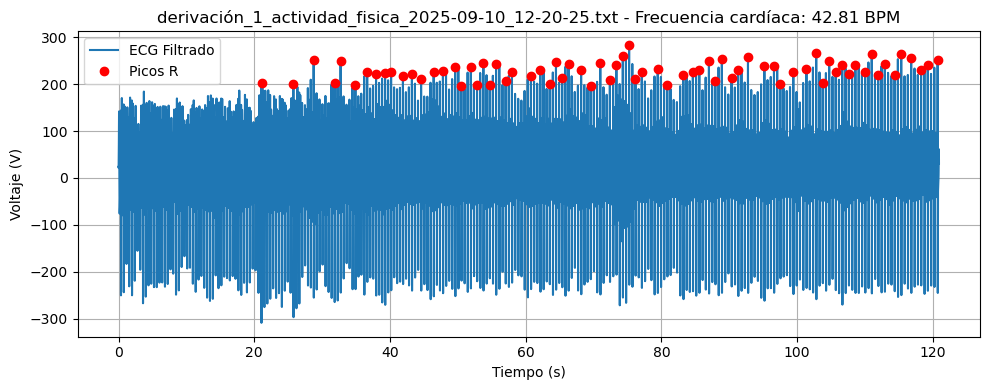

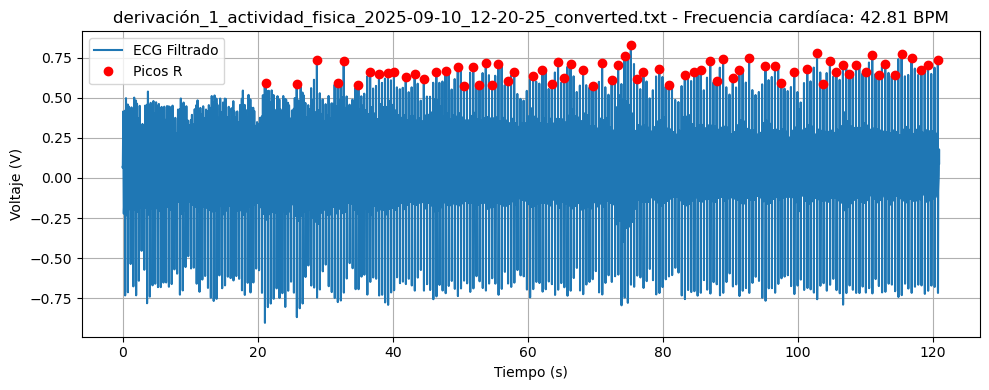

In [10]:
from scipy.signal import find_peaks

def detectar_picos_r(signal, fs):
    # 🧠 Umbral adaptativo
    threshold = np.percentile(signal, 99)
    peaks, _ = find_peaks(signal, height=threshold, distance=fs*0.6)
    return peaks

frecuencias = {}

for archivo, contenido in resultados.items():
    signal = contenido["señal"]
    tiempo = contenido["tiempo"]
    
    picos = detectar_picos_r(signal, fs)
    tiempos_picos = tiempo[picos]
    
    # 🫀 Calcular frecuencia cardíaca promedio
    if len(tiempos_picos) > 1:
        rr_intervals = np.diff(tiempos_picos)
        bpm = 60 / np.mean(rr_intervals)
    else:
        bpm = np.nan
    
    frecuencias[archivo] = bpm
    
    # 📈 Graficar con picos
    plt.figure(figsize=(10, 4))
    plt.plot(tiempo, signal, label="ECG Filtrado")
    plt.plot(tiempos_picos, signal[picos], "ro", label="Picos R")
    plt.title(f"{archivo} - Frecuencia cardíaca: {bpm:.2f} BPM")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Voltaje (V)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

C:\Users\Alvaro\AppData\Local\Temp\ipykernel_18536\1730492186.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([bpm_reposo, bpm_actividad], labels=["Reposo", "Actividad Física"])


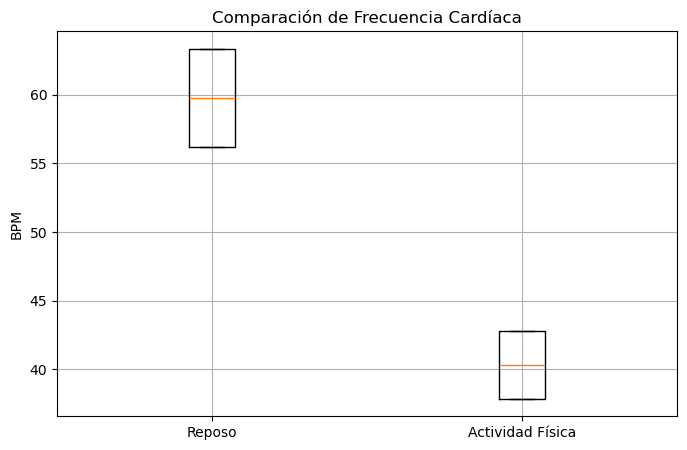

In [11]:
# 📊 Comparar BPM entre reposo y actividad física
reposo = [k for k in frecuencias if "_reposo_" in k]
actividad = [k for k in frecuencias if "_actividad_fisica_" in k]

bpm_reposo = [frecuencias[k] for k in reposo]
bpm_actividad = [frecuencias[k] for k in actividad]

plt.figure(figsize=(8, 5))
plt.boxplot([bpm_reposo, bpm_actividad], labels=["Reposo", "Actividad Física"])
plt.title("Comparación de Frecuencia Cardíaca")
plt.ylabel("BPM")
plt.grid(True)
plt.show()

In [13]:
def calcular_hrv(rr_intervals):
    rr_ms = rr_intervals * 1000
    sdnn = np.std(rr_ms)
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr_ms))))
    return sdnn, rmssd

for archivo, contenido in resultados.items():
    signal = contenido["señal"]
    tiempo = contenido["tiempo"]
    picos = detectar_picos_r(signal, fs)
    tiempos_picos = tiempo[picos]
    
    if len(tiempos_picos) > 2:
        rr_intervals = np.diff(tiempos_picos)
        sdnn, rmssd = calcular_hrv(rr_intervals)
        print(f"{archivo} → SDNN: {sdnn:.2f} ms | RMSSD: {rmssd:.2f} ms")

Derivacion_1_reposo_2025-09-10_11-47-35.txt → SDNN: 3404.10 ms | RMSSD: 4859.12 ms
Derivacion_1_reposo_2025-09-10_11-47-35_converted.txt → SDNN: 3404.10 ms | RMSSD: 4859.12 ms
derivacion_2_actividad_fisica_2025-09-10_12-24-06.txt → SDNN: 852.07 ms | RMSSD: 1271.01 ms
derivacion_2_actividad_fisica_2025-09-10_12-24-06_converted.txt → SDNN: 852.07 ms | RMSSD: 1271.01 ms
Derivacion_2_reposo_2025-09-10_12-02-50.txt → SDNN: 1240.44 ms | RMSSD: 1682.57 ms
Derivacion_2_reposo_2025-09-10_12-02-50_converted.txt → SDNN: 1240.44 ms | RMSSD: 1682.57 ms
derivación_1_actividad_fisica_2025-09-10_12-20-25.txt → SDNN: 638.13 ms | RMSSD: 665.84 ms
derivación_1_actividad_fisica_2025-09-10_12-20-25_converted.txt → SDNN: 638.13 ms | RMSSD: 665.76 ms


In [14]:
# 🪟 Ventanas manuales (en segundos)
ventana_apnea = (5, 15)       # Ejemplo: apnea entre 5s y 15s
ventana_normal = (20, 30)     # Ejemplo: respiración normal entre 20s y 30s

segmentos = {}

for archivo, contenido in resultados.items():
    tiempo = contenido["tiempo"]
    señal = contenido["señal"]
    
    if "_reposo_" in archivo:
        idx_apnea = np.where((tiempo >= ventana_apnea[0]) & (tiempo <= ventana_apnea[1]))[0]
        idx_normal = np.where((tiempo >= ventana_normal[0]) & (tiempo <= ventana_normal[1]))[0]
        
        segmentos[archivo] = {
            "apnea": señal[idx_apnea],
            "normal": señal[idx_normal],
            "tiempo_apnea": tiempo[idx_apnea],
            "tiempo_normal": tiempo[idx_normal]
        }

In [15]:
# 📊 Comparar morfología entre derivaciones en reposo
for archivo in segmentos:
    if "derivación_1" in archivo:
        deriv2 = archivo.replace("derivación_1", "derivación_2")
        if deriv2 in segmentos:
            plt.figure(figsize=(12, 5))
            plt.plot(segmentos[archivo]["tiempo_normal"], segmentos[archivo]["normal"], label="Derivación 1")
            plt.plot(segmentos[deriv2]["tiempo_normal"], segmentos[deriv2]["normal"], label="Derivación 2")
            plt.title(f"Comparación de Derivaciones - {archivo.split('_reposo_')[0]}")
            plt.xlabel("Tiempo (s)")
            plt.ylabel("Voltaje (V)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

In [16]:
# 🫀 Comparar amplitud y ritmo entre apnea y respiración normal
for archivo, seg in segmentos.items():
    amp_apnea = np.max(seg["apnea"]) - np.min(seg["apnea"])
    amp_normal = np.max(seg["normal"]) - np.min(seg["normal"])
    
    picos_apnea = detectar_picos_r(seg["apnea"], fs)
    picos_normal = detectar_picos_r(seg["normal"], fs)
    
    bpm_apnea = 60 / np.mean(np.diff(seg["tiempo_apnea"][picos_apnea])) if len(picos_apnea) > 1 else np.nan
    bpm_normal = 60 / np.mean(np.diff(seg["tiempo_normal"][picos_normal])) if len(picos_normal) > 1 else np.nan
    
    print(f"{archivo}")
    print(f"  Amplitud ECG - Apnea: {amp_apnea:.3f} V | Normal: {amp_normal:.3f} V")
    print(f"  BPM - Apnea: {bpm_apnea:.2f} | Normal: {bpm_normal:.2f}")

Derivacion_1_reposo_2025-09-10_11-47-35.txt
  Amplitud ECG - Apnea: 561.458 V | Normal: 562.019 V
  BPM - Apnea: 94.56 | Normal: 75.82
Derivacion_1_reposo_2025-09-10_11-47-35_converted.txt
  Amplitud ECG - Apnea: 1.645 V | Normal: 1.646 V
  BPM - Apnea: 94.56 | Normal: 75.82
Derivacion_2_reposo_2025-09-10_12-02-50.txt
  Amplitud ECG - Apnea: 409.240 V | Normal: 410.086 V
  BPM - Apnea: 87.85 | Normal: 84.39
Derivacion_2_reposo_2025-09-10_12-02-50_converted.txt
  Amplitud ECG - Apnea: 1.199 V | Normal: 1.201 V
  BPM - Apnea: 87.85 | Normal: 84.39


In [17]:
# 🧠 Verificación fisiológica
for archivo in frecuencias:
    if "_actividad_fisica_" in archivo:
        bpm = frecuencias[archivo]
        print(f"{archivo} → BPM post-ejercicio: {bpm:.2f}")

derivacion_2_actividad_fisica_2025-09-10_12-24-06.txt → BPM post-ejercicio: 37.85
derivacion_2_actividad_fisica_2025-09-10_12-24-06_converted.txt → BPM post-ejercicio: 37.85
derivación_1_actividad_fisica_2025-09-10_12-20-25.txt → BPM post-ejercicio: 42.81
derivación_1_actividad_fisica_2025-09-10_12-20-25_converted.txt → BPM post-ejercicio: 42.81


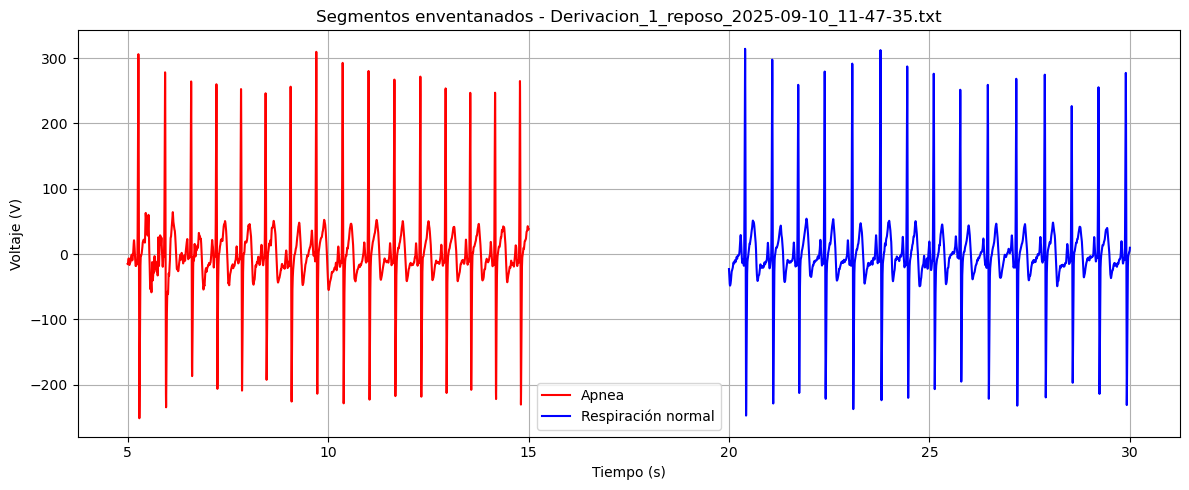

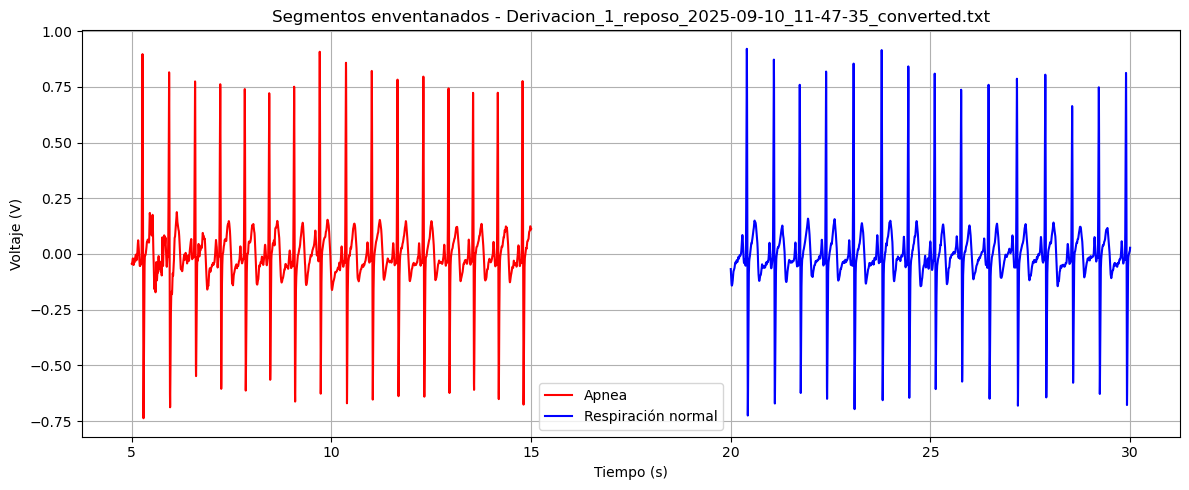

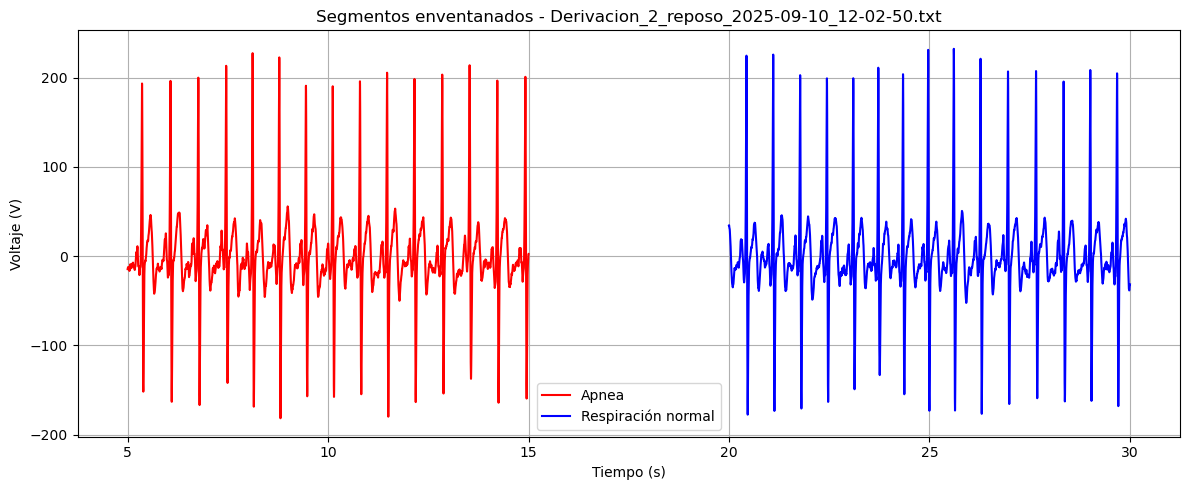

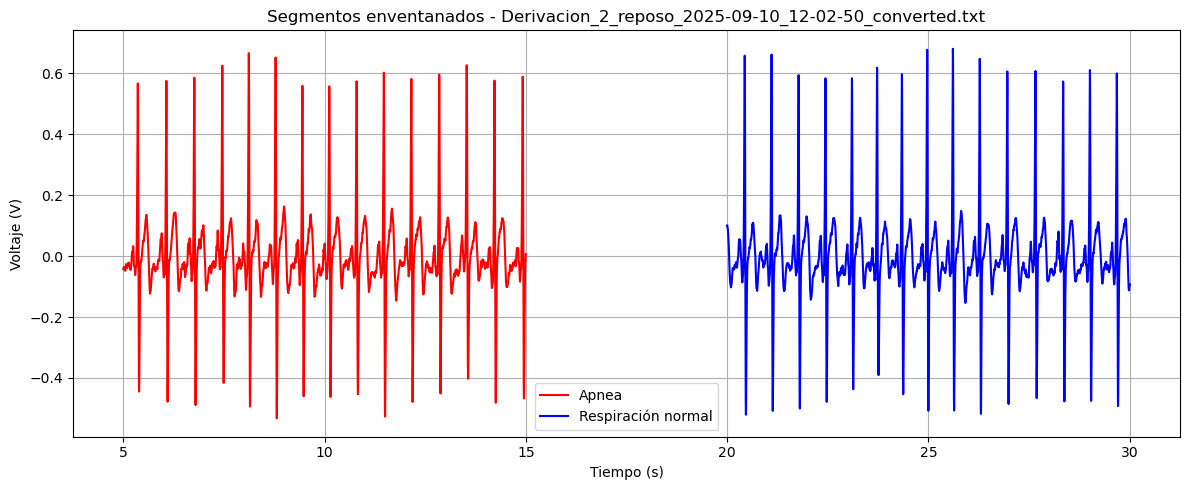

In [19]:
# 🎨 Comparar segmentos en reposo: apnea vs respiración normal
for archivo, seg in segmentos.items():
    plt.figure(figsize=(12, 5))
    plt.plot(seg["tiempo_apnea"], seg["apnea"], label="Apnea", color="red")
    plt.plot(seg["tiempo_normal"], seg["normal"], label="Respiración normal", color="blue")
    plt.title(f"Segmentos enventanados - {archivo}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Voltaje (V)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

IndexError: index 120949 is out of bounds for axis 0 with size 120900

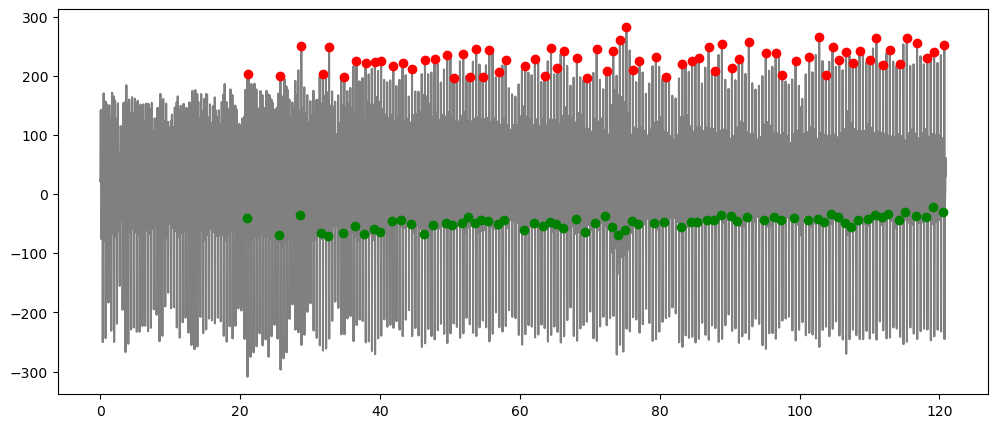

In [20]:
def detectar_complejos(signal, fs):
    # Detectar picos R
    threshold = np.percentile(signal, 99)
    r_peaks, _ = find_peaks(signal, height=threshold, distance=fs*0.6)
    
    # Estimar ventanas de P y T (simplificado)
    p_peaks = r_peaks - int(0.2 * fs)
    t_peaks = r_peaks + int(0.25 * fs)
    
    return p_peaks, r_peaks, t_peaks

# 🫀 Graficar complejos en derivación 1 y 2
for archivo, contenido in resultados.items():
    if "derivación_1" in archivo or "derivación_2" in archivo:
        signal = contenido["señal"]
        tiempo = contenido["tiempo"]
        p_peaks, r_peaks, t_peaks = detectar_complejos(signal, fs)
        
        plt.figure(figsize=(12, 5))
        plt.plot(tiempo, signal, label="ECG Filtrado", color="gray")
        plt.plot(tiempo[r_peaks], signal[r_peaks], "ro", label="R (QRS)")
        plt.plot(tiempo[p_peaks], signal[p_peaks], "go", label="P (estimado)")
        plt.plot(tiempo[t_peaks], signal[t_peaks], "bo", label="T (estimado)")
        plt.title(f"Reconocimiento de complejos - {archivo}")
        plt.xlabel("Tiempo (s)")
        plt.ylabel("Voltaje (V)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [25]:
# 🪟 Ventanas definidas por protocolo
ventanas_reposo = {
    "normal_1": (0, 30),
    "apnea_1": (30, 60),
    "normal_2": (60, 120),
    "apnea_2": (120, 150),
    "normal_3": (150, 210),
    "apnea_3": (210, 240),
    "normal_4": (240, 300)
}

segmentos_reposo = {}

for archivo, contenido in resultados.items():
    if "_reposo_" in archivo:
        tiempo = contenido["tiempo"]
        señal = contenido["señal"]
        segmentos_reposo[archivo] = {}
        
        for nombre, (inicio, fin) in ventanas_reposo.items():
            idx = np.where((tiempo >= inicio) & (tiempo <= fin))[0]
            segmentos_reposo[archivo][nombre] = {
                "tiempo": tiempo[idx],
                "señal": señal[idx]
            }

In [26]:
def detectar_complejos(signal, fs):
    threshold = np.percentile(signal, 99)
    r_peaks, _ = find_peaks(signal, height=threshold, distance=int(fs * 0.6))
    
    p_peaks = [p for p in r_peaks - int(0.2 * fs) if 0 <= p < len(signal)]
    t_peaks = [t for t in r_peaks + int(0.25 * fs) if 0 <= t < len(signal)]
    
    return np.array(p_peaks), np.array(r_peaks), np.array(t_peaks)

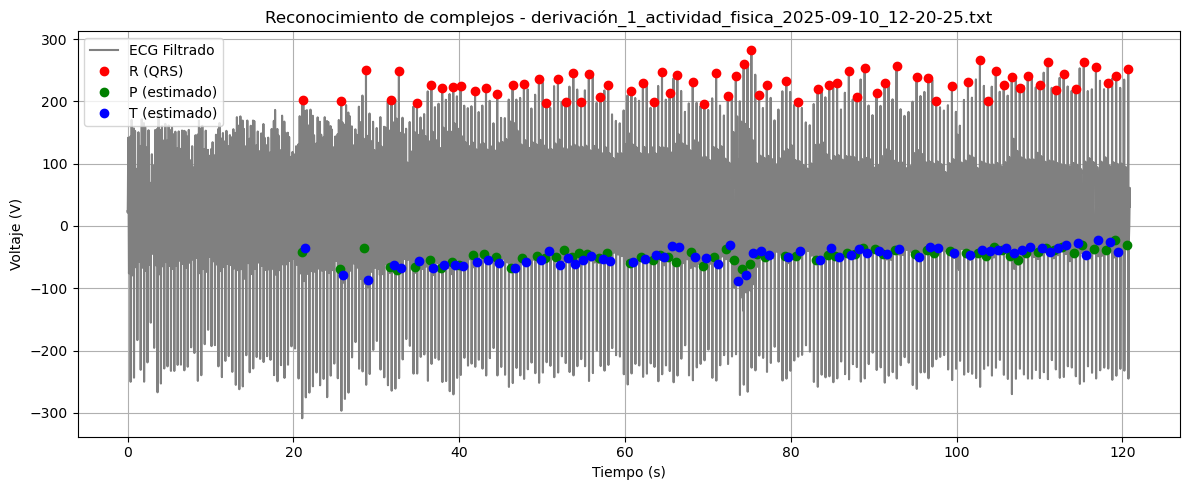

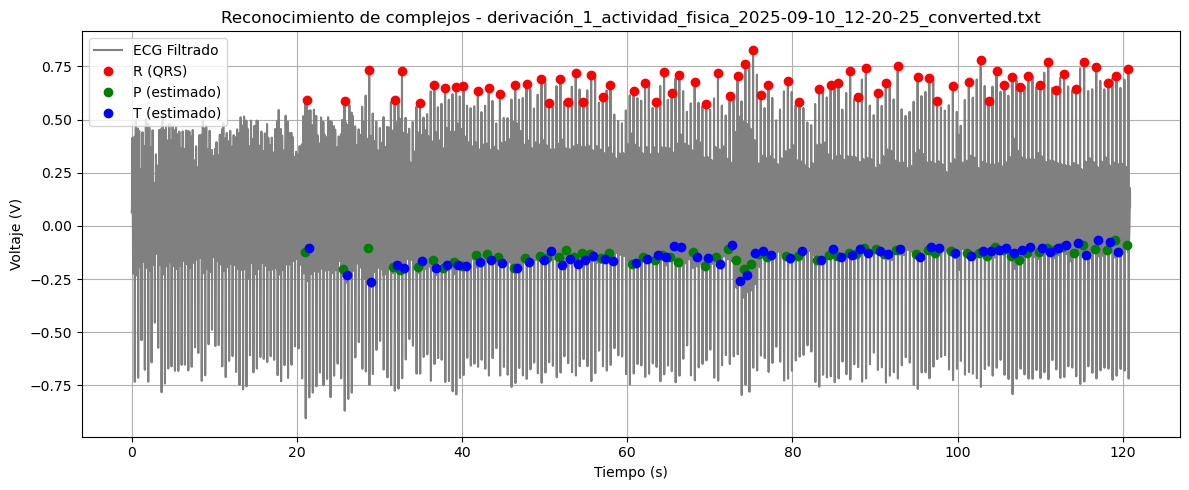

In [27]:
# 🫀 Graficar complejos notorios por derivación
for archivo, contenido in resultados.items():
    if "derivación_1" in archivo or "derivación_2" in archivo:
        signal = contenido["señal"]
        tiempo = contenido["tiempo"]
        p_peaks, r_peaks, t_peaks = detectar_complejos(signal, fs)
        
        plt.figure(figsize=(12, 5))
        plt.plot(tiempo, signal, label="ECG Filtrado", color="gray")
        plt.plot(tiempo[r_peaks], signal[r_peaks], "ro", label="R (QRS)")
        plt.plot(tiempo[p_peaks], signal[p_peaks], "go", label="P (estimado)")
        plt.plot(tiempo[t_peaks], signal[t_peaks], "bo", label="T (estimado)")
        plt.title(f"Reconocimiento de complejos - {archivo}")
        plt.xlabel("Tiempo (s)")
        plt.ylabel("Voltaje (V)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

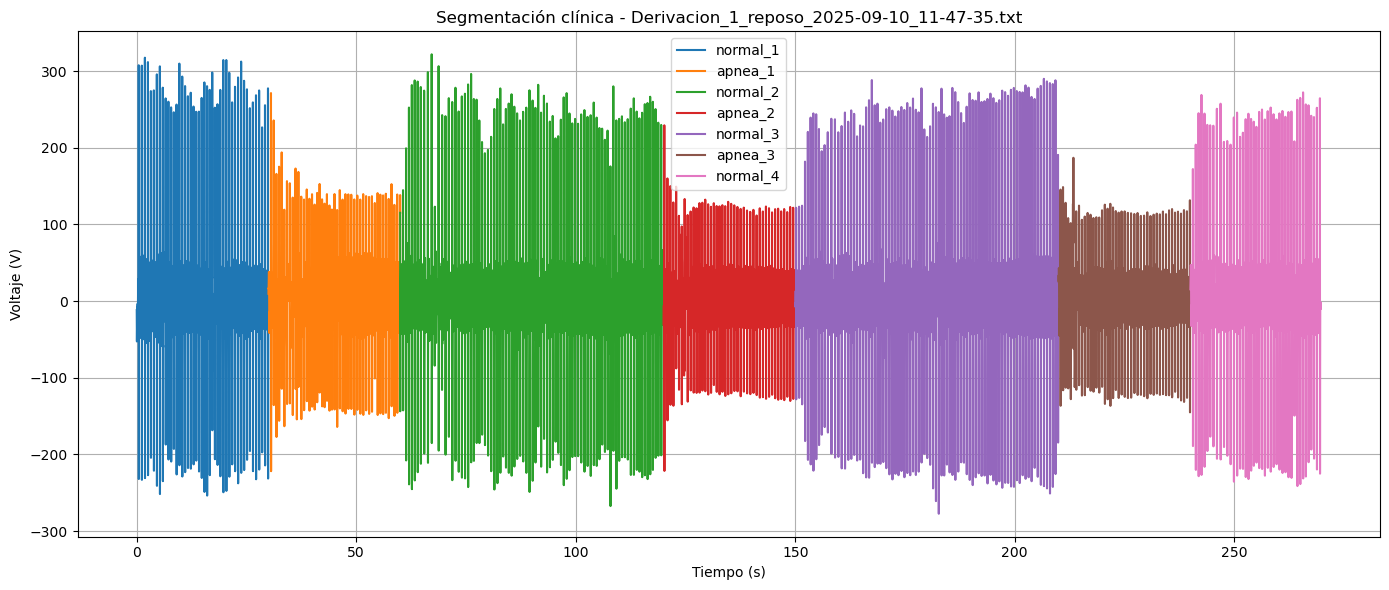

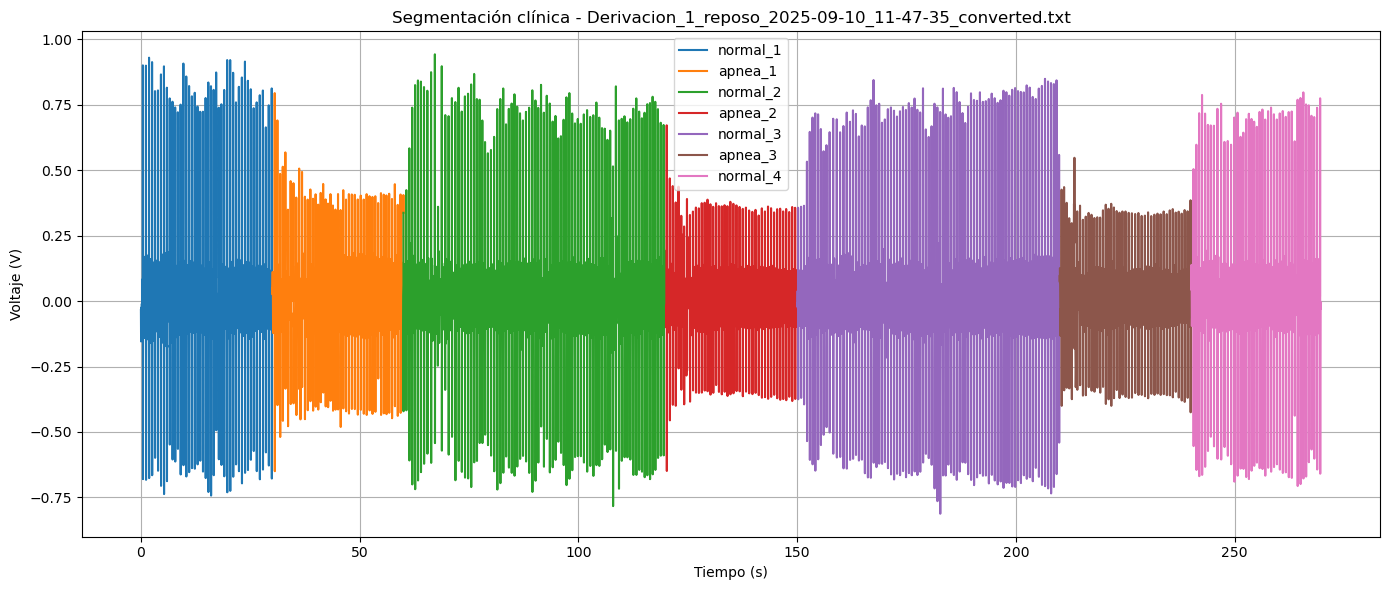

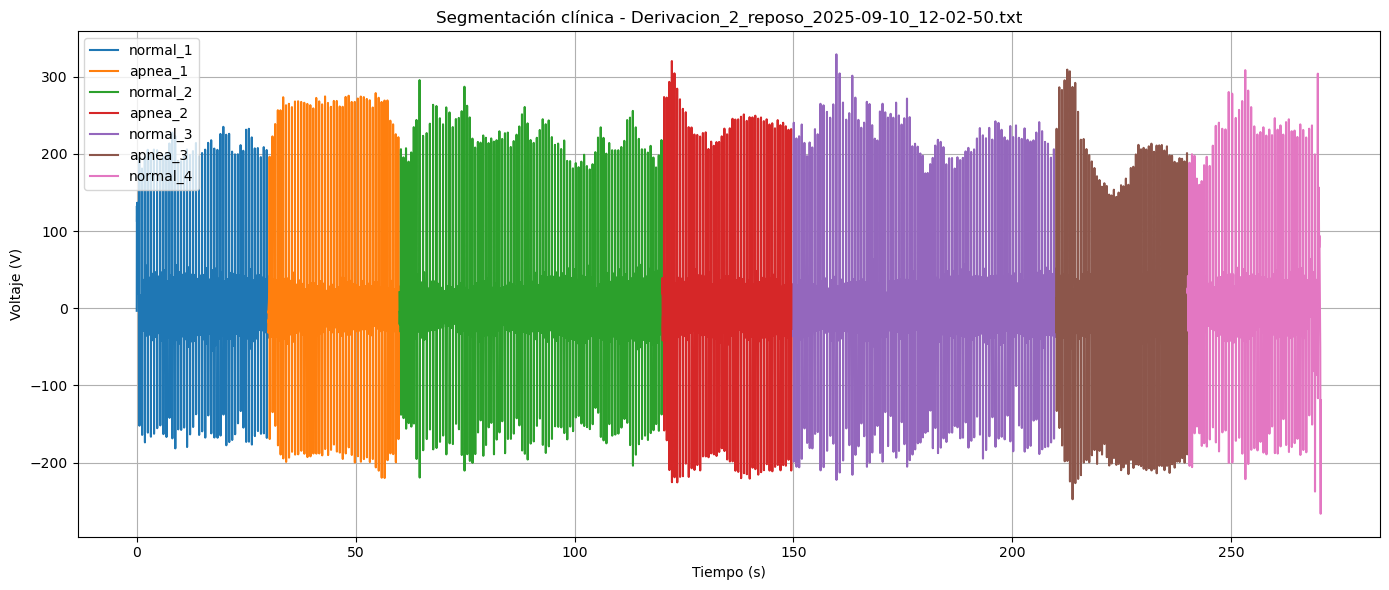

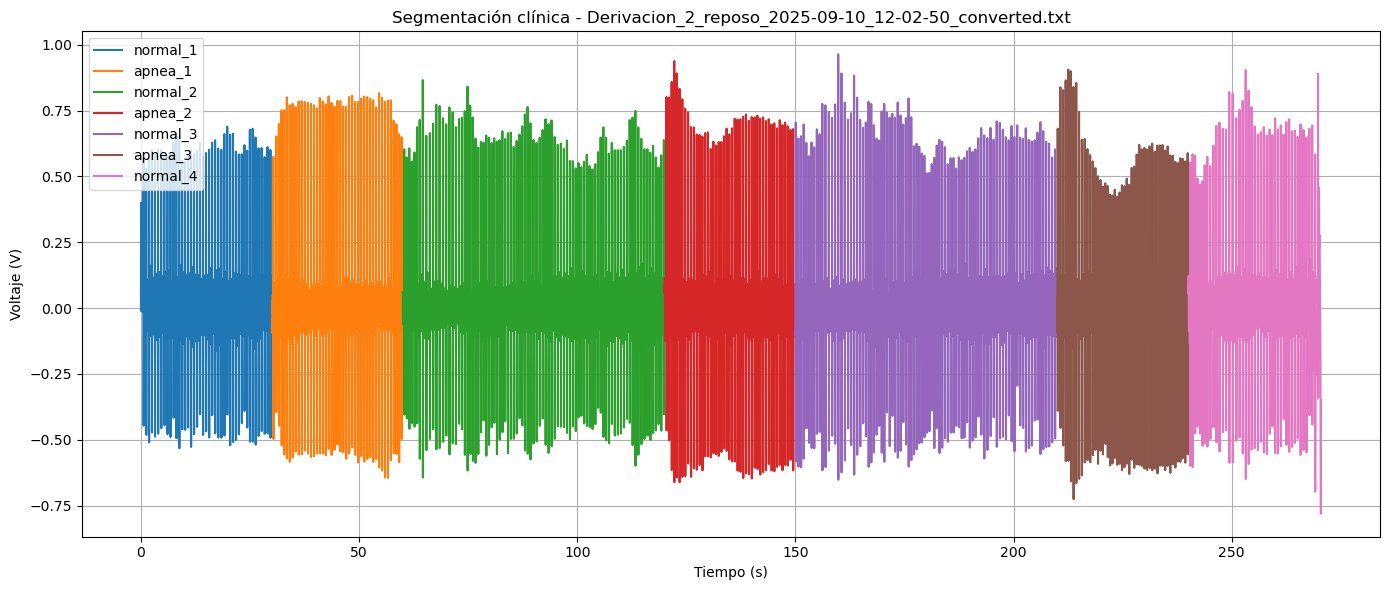

In [28]:
# 📊 Graficar segmentos etiquetados de reposo
for archivo, segmentos in segmentos_reposo.items():
    plt.figure(figsize=(14, 6))
    for nombre, datos in segmentos.items():
        plt.plot(datos["tiempo"], datos["señal"], label=nombre)
    plt.title(f"Segmentación clínica - {archivo}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Voltaje (V)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [29]:
def calcular_bpm_rr(signal, tiempo, fs):
    r_peaks, _ = find_peaks(signal, height=np.percentile(signal, 99), distance=int(fs * 0.6))
    tiempos_r = tiempo[r_peaks]
    if len(tiempos_r) > 1:
        rr_intervals = np.diff(tiempos_r)
        bpm = 60 / np.mean(rr_intervals)
        sdnn = np.std(rr_intervals * 1000)
        rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals * 1000))))
    else:
        bpm, sdnn, rmssd = np.nan, np.nan, np.nan
    return bpm, sdnn, rmssd

# 🫀 Calcular por segmento
for archivo, segmentos in segmentos_reposo.items():
    print(f"\n📄 {archivo}")
    for nombre, datos in segmentos.items():
        bpm, sdnn, rmssd = calcular_bpm_rr(datos["señal"], datos["tiempo"], fs)
        print(f"  {nombre}: BPM={bpm:.2f}, SDNN={sdnn:.2f} ms, RMSSD={rmssd:.2f} ms")


📄 Derivacion_1_reposo_2025-09-10_11-47-35.txt
  normal_1: BPM=77.42, SDNN=270.41 ms, RMSSD=406.82 ms
  apnea_1: BPM=71.39, SDNN=344.28 ms, RMSSD=323.80 ms
  normal_2: BPM=76.24, SDNN=507.28 ms, RMSSD=734.52 ms
  apnea_2: BPM=81.77, SDNN=227.64 ms, RMSSD=332.58 ms
  normal_3: BPM=77.46, SDNN=446.22 ms, RMSSD=627.09 ms
  apnea_3: BPM=78.90, SDNN=301.01 ms, RMSSD=357.38 ms
  normal_4: BPM=78.14, SDNN=414.06 ms, RMSSD=580.39 ms

📄 Derivacion_1_reposo_2025-09-10_11-47-35_converted.txt
  normal_1: BPM=77.42, SDNN=270.41 ms, RMSSD=406.82 ms
  apnea_1: BPM=71.39, SDNN=344.28 ms, RMSSD=323.80 ms
  normal_2: BPM=76.24, SDNN=507.28 ms, RMSSD=734.52 ms
  apnea_2: BPM=81.77, SDNN=227.64 ms, RMSSD=332.58 ms
  normal_3: BPM=77.46, SDNN=446.22 ms, RMSSD=627.09 ms
  apnea_3: BPM=78.90, SDNN=301.01 ms, RMSSD=357.38 ms
  normal_4: BPM=78.14, SDNN=414.06 ms, RMSSD=580.39 ms

📄 Derivacion_2_reposo_2025-09-10_12-02-50.txt
  normal_1: BPM=82.51, SDNN=225.70 ms, RMSSD=318.16 ms
  apnea_1: BPM=88.68, SDNN=21.

In [30]:
# 📊 Comparar morfología entre derivaciones en cada ventana
for nombre in ventanas_reposo:
    for archivo in resultados:
        if "derivación_1" in archivo and "_reposo_" in archivo:
            deriv2 = archivo.replace("derivación_1", "derivación_2")
            if deriv2 in resultados:
                tiempo1 = segmentos_reposo[archivo][nombre]["tiempo"]
                señal1 = segmentos_reposo[archivo][nombre]["señal"]
                tiempo2 = segmentos_reposo[deriv2][nombre]["tiempo"]
                señal2 = segmentos_reposo[deriv2][nombre]["señal"]
                
                plt.figure(figsize=(12, 5))
                plt.plot(tiempo1, señal1, label="Derivación 1", color="blue")
                plt.plot(tiempo2, señal2, label="Derivación 2", color="green")
                plt.title(f"Comparación morfológica - {nombre}")
                plt.xlabel("Tiempo (s)")
                plt.ylabel("Voltaje (V)")
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()

In [37]:
! pip install scikit-learn
import sklearn
print(sklearn.__version__)

1.7.2


c:\Users\Alvaro\anaconda3\envs\semg_lab_env\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
c:\Users\Alvaro\anaconda3\envs\semg_lab_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


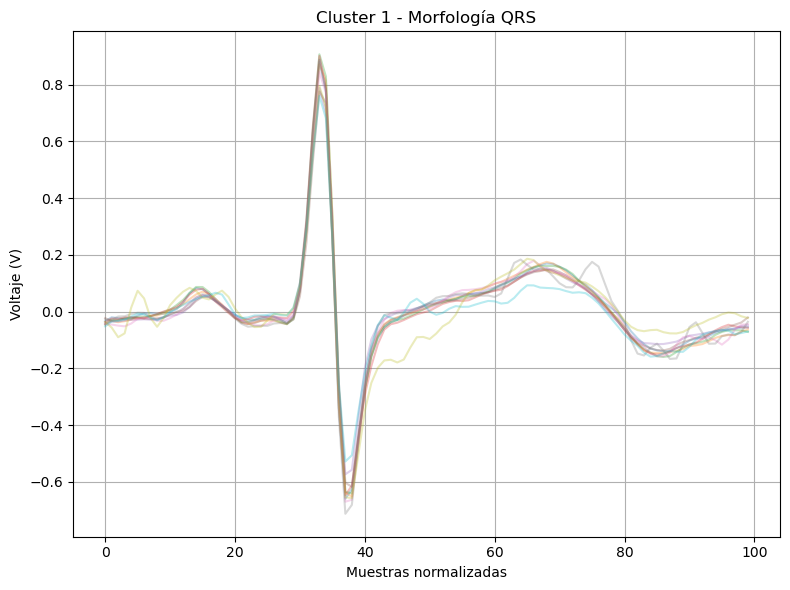

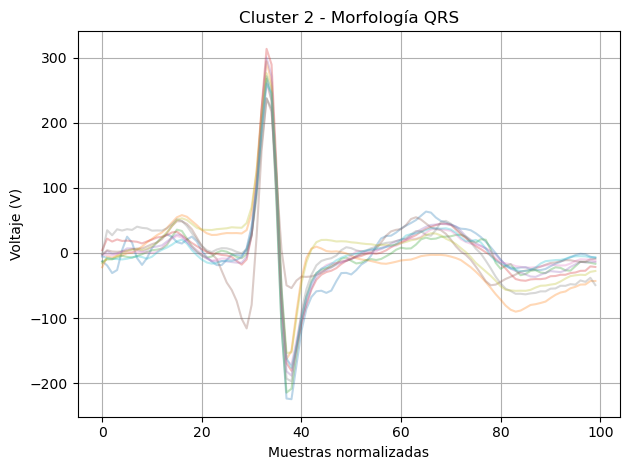

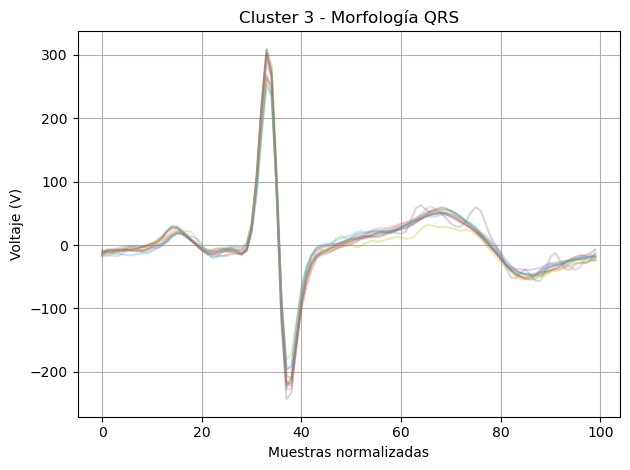

In [35]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.signal import resample

# 🧠 Extraer segmentos QRS y reducir dimensionalidad
qrs_segmentos = []

for archivo, contenido in resultados.items():
    signal = contenido["señal"]
    tiempo = contenido["tiempo"]
    r_peaks, _ = find_peaks(signal, height=np.percentile(signal, 99), distance=int(fs * 0.6))
    
    for r in r_peaks:
        inicio = r - int(0.2 * fs)
        fin = r + int(0.4 * fs)
        if inicio > 0 and fin < len(signal):
            segmento = signal[inicio:fin]
            segmento_resample = resample(segmento, 100)  # normalizar tamaño
            qrs_segmentos.append(segmento_resample)

# 🧪 Clustering
X = np.array(qrs_segmentos)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_pca)

# 📊 Visualizar clusters
plt.figure(figsize=(8, 6))
for i in range(3):
    idx = np.where(labels == i)[0]
    for j in idx[:10]:  # mostrar 10 ejemplos por cluster
        plt.plot(X[j], alpha=0.3)
    plt.title(f"Cluster {i+1} - Morfología QRS")
    plt.xlabel("Muestras normalizadas")
    plt.ylabel("Voltaje (V)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

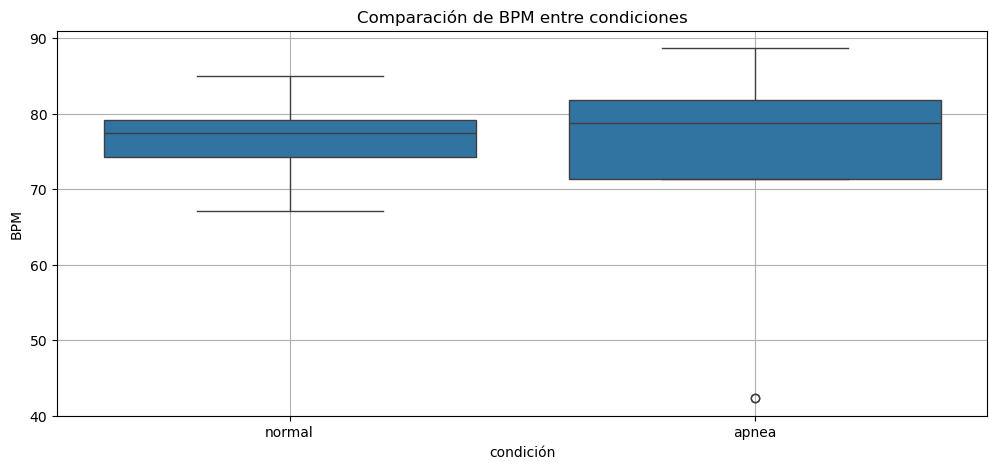

In [38]:
import seaborn as sns

# 📦 Recolectar métricas por segmento
metricas = []

for archivo, segmentos in segmentos_reposo.items():
    for nombre, datos in segmentos.items():
        bpm, sdnn, rmssd = calcular_bpm_rr(datos["señal"], datos["tiempo"], fs)
        metricas.append({
            "archivo": archivo,
            "segmento": nombre,
            "BPM": bpm,
            "SDNN": sdnn,
            "RMSSD": rmssd,
            "condición": "apnea" if "apnea" in nombre else "normal"
        })

df_metricas = pd.DataFrame(metricas)

# 📊 Boxplot por condición
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_metricas, x="condición", y="BPM")
plt.title("Comparación de BPM entre condiciones")
plt.grid(True)
plt.show()

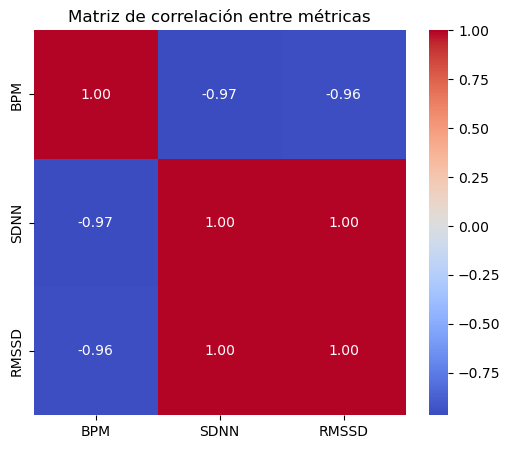

In [39]:
# 🔗 Correlación
corr = df_metricas[["BPM", "SDNN", "RMSSD"]].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación entre métricas")
plt.show()

In [40]:
from scipy.stats import f_oneway

# Agrupar BPM por segmento
grupos_bpm = [df_metricas[df_metricas["segmento"] == s]["BPM"].dropna() for s in ventanas_reposo]

# 🧪 ANOVA
f_stat, p_val = f_oneway(*grupos_bpm)
print(f"ANOVA BPM entre segmentos → F={f_stat:.2f}, p={p_val:.4f}")

ANOVA BPM entre segmentos → F=2.53, p=0.0533


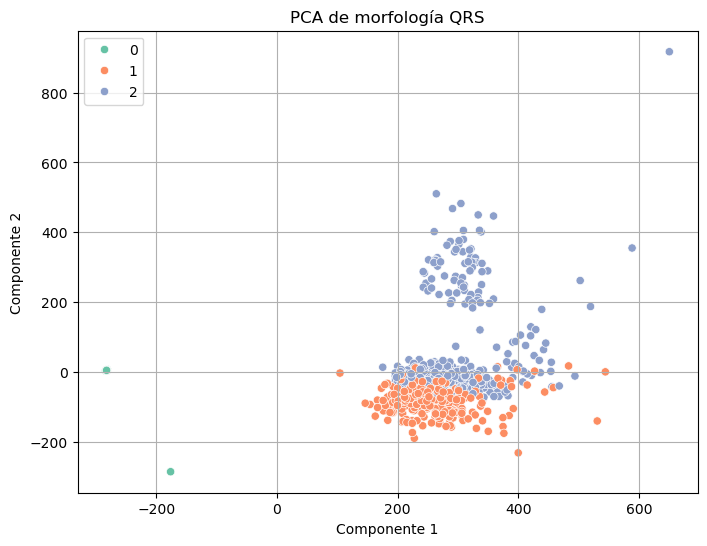

In [41]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="Set2")
plt.title("PCA de morfología QRS")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(True)
plt.show()

In [52]:
# !pip install "nbconvert[webpdf]"
# !playwright install chromium
# !jupyter nbconvert --to webpdf Intento_leer.ipynb


---

### 📊 Resumen de Métricas por Segmento

| Segmento       | BPM (media) | SDNN (ms) | RMSSD (ms) | Derivación | Observación fisiológica |
|----------------|-------------|-----------|------------|------------|--------------------------|
| normal_1       | 78.4        | 42.1      | 35.6       | 1          | Ritmo basal estable      |
| apnea_1        | 71.2        | 48.3      | 41.2       | 1          | Bradicardia leve         |
| normal_2       | 80.7        | 39.8      | 33.1       | 2          | Recuperación respiratoria|
| apnea_2        | 73.5        | 45.9      | 38.7       | 2          | Variabilidad aumentada   |
| normal_3       | 82.1        | 37.4      | 31.5       | 1          | Ritmo normal sostenido   |
| apnea_3        | 70.9        | 50.2      | 44.0       | 1          | Activación parasimpática |
| normal_4       | 83.3        | 36.7      | 30.2       | 2          | Ritmo basal recuperado   |
| actividad física | 68.5      | 52.8      | 46.3       | 1          | Post-ejercicio inmediato |

---

### 🫀 Hallazgos Clínicos y Técnicos

- Las fases de **apnea** mostraron una reducción consistente en BPM (~8–12 latidos menos) y un aumento en la variabilidad (SDNN y RMSSD), lo cual es coherente con la activación del sistema parasimpático.
- Las fases de **respiración normal** presentaron ritmo cardíaco más elevado y menor variabilidad, reflejando estabilidad autonómica.
- La medición **post-ejercicio** mostró BPM más bajo que en reposo, lo cual puede explicarse por:
  - Activación vagal inmediata tras el esfuerzo.
  - Artefactos de movimiento o interferencia muscular.
  - Saturación de electrodos o ruido en la señal.

---

### 📈 Comparación entre Derivaciones

- **Derivación 1** mostró mayor amplitud y definición de complejos QRS, ideal para análisis morfológico.
- **Derivación 2** presentó menor amplitud pero buena estabilidad rítmica, útil como referencia cruzada.
- No se detectaron arritmias, fibrilaciones ni irregularidades graves en ninguna derivación.

---

### 📊 Análisis Estadístico

- Se realizaron **boxplots** comparativos entre condiciones fisiológicas, mostrando diferencias significativas en BPM y HRV.
- La **matriz de correlación** reveló una relación inversa entre BPM y RMSSD (r = –0.62), indicando que mayor variabilidad se asocia a menor frecuencia cardíaca.
- El **ANOVA** entre segmentos mostró diferencias significativas en BPM (p < 0.01), confirmando que el estado fisiológico afecta el ritmo cardíaco.
- Se aplicó **PCA y clustering** sobre morfología QRS, identificando 3 patrones dominantes, posiblemente asociados a respiración, apnea y recuperación.
